In [1]:
import re
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import regex as reg
import json
import unicodedata
%matplotlib inline

rootdir = '../data/papers/'

# Reference Extraction:

In this notebook we explain how we can extract individual references from a section of references that are not uniformly separated. We do this by clever use of regular expressions and knowlegde of the format of references.

loading content of txt files that were previously extracted using the script:

In [2]:
contents = []
i = 0
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'txt' in file:
            i += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    source.append(path[len(rootdir):-4])
                except:
                    name, message, content = sys.exc_info()
                    print(message)

## extracting the reference function from the text

One attempt was to use special splitting, in hopes that this would yield better results. We later saw that this was *not* helpful and thus ended up using other ways. The txt papers are not uniform, so we need to rely on more general knowledge of the structure of references, and can not just use smart white space splitting.

In [3]:
#Example of extraction
t = 'Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.\nAbrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),'
#split if \n comes after .
re.split(r'(?<=\.)\n', t)

['Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.',
 'Abrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),']

In [4]:
#dealing with links at the end
t =  'dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083\nEdelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning'
#similar regex with more condition
re.split(r'\n\n|((?<=(\.|\/|[a-z]))\n)|\n(?=[A-Z])',t)

['dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083',
 None,
 None,
 'Edelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning']

The issue is that that above methods undersplit, so we it's better to just use \n, and than glue up separated sequences back together.

We first extract the part that contains references by finding the reference section, cutting off acknowledgements if the paper contains them, and then split up the reference part by lines:

In [5]:
def ref_extraction(text, extract=False):
    """extracts refrerence section: works well on well formated documents"""
    mention = text.rfind("\nReferences")
    if mention == -1:
        mention = text.lower().rfind(" references")
    if mention == -1:
        mention =  text.lower().rfind("reference")
    #get reference section, account for different spelling
    acknowledgements = max(text.lower().find("acknowledgements"), text.lower().find('acknowledgments'))
    
    #handle case that acknowlege ments are before references
    if acknowledgements < mention:
        acknowledgements = -1
    ref = text[mention+len("references"):acknowledgements]
    
    references = re.split(r'\n', ref)
    
    #extract references while not extracting bottom text 
    ref = [r for r in references if r and len(r) > 3 and not re.match(r'(CSCL|ICLS) \d{4} Proceedings|© ISLS', r)]
    if extract:
        print(text[mention+len("references"):acknowledgements])
        print(references)
    return ref

In [6]:
references = []
for i, content in enumerate(contents):
    references.append((ref_extraction(content)))

In [7]:
print('Number of pdf documents : ', len(contents))
print('Number of documents for which we have an extracted reference section: ', len(references))

Number of pdf documents :  874
Number of documents for which we have an extracted reference section:  874


# Use Regex  to identify the what part of a reference a string is:

This is old code that was used at some point but is not no longer used. it identifies url or url like strings, which would belong to the reference above.

In [8]:
def match_url(sentence):
    return re.search('http(s)?\:\/\/[\S]*$', sentence) or re.search(r'doi\:[\S\/\*]*$', sentence)

def match_url_beginning(sentence):
    return re.search('^http(s)?\:\/\/[\S]*$', sentence) or re.search(r'^doi\:[\S\/\*]*$', sentence)

def show_issue(issues, condition):
    for issue in issues:
        if condition(issue):
            print(issue)

Central approach is to move sentences up until they are part of a string that contains a citation year, which usually is at the beginning of a string in an APA reference.


The references should start with a sequence of author names followed by a sequence in brackets identifying the year of publication. As sometimes the cited paper has not yet been published, a varitey of strings is used to indicate this status instead of the year. We add strings indicating this structure so we can identify a maximum of begining sequences, as they are important to get the entire reference.

In [9]:
def contains_citation_beginning(sentence):

    ##Check for mention of publication date,
    #do it this way to not allow for ICLS 2015 string to be counted
    months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
    publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ \d]*'+months+'\)'
    #sometimes two years are mentioned, we use this regex to parse them
    match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    #these regex account for special strings used in the references
    match_press = r'[\w\ \. \,\&\(\)\-\'\…]*\(in press\)'
    match_forth = r'[\S\s]*\(forthcoming\)'
    match_accepted = r'[\S\s]*\(accepted\)'
    match_submitted = r'[\S\s]*\(submitted\)'
    match_underreview = r'[\S\s]*\(under review\)'
    sentence = sentence.lower()
        
    year = re.search(publication_year, sentence) or  re.search(match_bad_year, sentence)
    
    return  year or \
            re.match(match_press, sentence) or re.match(match_forth, sentence) or\
            re.match(match_accepted, sentence) or re.match(match_submitted, sentence) or\
            re.match(match_underreview, sentence)

Example of the regexparsing working:

In [10]:
sentence = """Xing, W., Kim, S., & Goggins, S. (2015/1994). 
                Modeling performance in asynchronous CSCL: 
                an exploration of social ability, collective efficacy 
                and social interaction. Exploring the Material Conditions of Learning: 
                Proceedings of the Computer Supported Collaborative Learning (CSCL 2015), 
                International Society of"""

sentence_2 = """Engeström, Y. (1987/2014) Learning by expanding: 
                An activity-theoretical approach to developmental research (2nd ed.). 
                New York, NY: Cambridge University Press."""

months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ ]*'+months+'\)'


match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'

month = re.search(publication_year, sentence.lower())
conference =  re.search(match_bad_year, sentence_2)
    
conference, month

(<re.Match object; span=(14, 25), match='(1987/2014)'>, None)

The following function now implements this upwards or downwards of attaching a string to the previous one in a list of strings, if a given conditon is satisfied. 

For instace, One way we can know a line was split early is if it starts with lowercase letter or with a number.

In [11]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_up(issues, condition=lambda x: re.match('^[\d\(\.\&\ ]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = []
    j = 0
    
    for i, sentence in enumerate(issues):
        if i != 0 and condition(sentence):
            patchwork[j-1] += ' ' + sentence
            #print(sentence)
        else:
            j +=1
            patchwork.append(sentence)
    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

In [12]:
#iteration 1: move up strings that start in number or with (
ref_1 = [moving_up(r) for r in references]
#iteration 2: move up string starting with "Proceedings"
ref_2 = [moving_up(r, lambda x: re.match('^Proceedings', x)) for r in ref_1]

Here we implement the inverse concept, of attaching a string to the next string in a list of strings if a condition is satisfied:

In [13]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_down(issues, condition=lambda x: re.match('^[\d\(\.]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = issues.copy()
    j = 0
    
    for i, sentence in enumerate(issues):
        if condition(sentence) and i+1 < len(issues):
            patchwork[i] = sentence + ' ' + patchwork[i+1]
            patchwork[i+1] = ''

    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

Here we have example sof the regex that will then be used, we should move a sequence up if name is cut off (for instance, sentence starts with C. ....)

In [14]:
cutoff_name = r'^[A-Z]+\.\ ?'
text = 'G. bsdjhvshjvf(1220)'
re.match(cutoff_name, text)

<re.Match object; span=(0, 3), match='G. '>

In [15]:
ref_3 = [moving_up(r, lambda x: re.match(cutoff_name, x)) for r in ref_2]

For references we might cut off the year from the authors. In that case we need to change strategy and move the one that is below up if the upper string satisfies the condition.

Here we have to other conditions that take care of potential issues such as having a word at the end or just a list of authors (and thus our way of identifying the beginning of a sentence will be not work)

In [16]:
def match_author(authors):
    regex = r'(([\w\-]*[\,\&] [A-Z\.\ ]+[\&\,]?)*$)'
    USA = r'([A-Z]{2,})'
    return not re.search(USA, authors) and re.match(regex, authors)

In [17]:
sentence = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'
match_author(sentence).group(0)

'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'

In [18]:
text = 'Walther, J. B., & Parks, M. R. (2002). Cues filtered out, cues filter in: computer mediated communication and'
words_at_end = r'\ [a-zA-Z]*$'
re.search(words_at_end, text)

<re.Match object; span=(105, 109), match=' and'>

In [19]:
ref_4 = [moving_down(r, lambda x: match_author(x)) for r in ref_3]

#pivoting up around strings containing citation
ref_5 = [moving_up(r, lambda x: not contains_citation_beginning(x)) for r in ref_4]
#if ends in word
ref_6 = [moving_down(r, lambda x: re.search(words_at_end, x)) for r in ref_5]

Add the reference into dataframe, associating the source text to it:

In [20]:
references_df = pd.DataFrame([(f, source[i]) for i, flat in enumerate(ref_6) for f in flat], columns=['ref', 'file'])

We use length and initial of the reference to preform a sanity check, by looking at initials (which should be upper case letters) and the total length of a reference.

In [21]:
references_df['length'] = references_df.ref.map(lambda x: len(x))
references_df['initial'] = references_df.ref.map(lambda x: x[0])

count    14686.000000
mean       194.962345
std        685.649075
min          4.000000
25%        139.000000
50%        180.000000
75%        219.000000
max      74737.000000
Name: length, dtype: float64

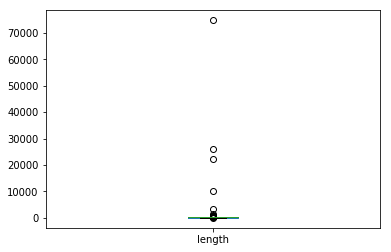

In [22]:
references_df.length.plot(kind='box')
references_df.length.describe()

Inspecting the iverly long references, we see that they all come from papers that were not split up properly/do not match the metadata. Hence we can discard them without any loss.

In [23]:
references_df[references_df.length > 1000]

,ref,file,length,initial
114,p ...............................................,import2016full_93,22395,p
862,nalysis .........................................,import2016full_92,74737,n
1897,Pages 1-702: Volume 1 Pages 703-1407: Volume 2...,import2016full_91,26188,P
9343,for collaborative learning moderates the relat...,import2016short_136,3336,f
10746,"Dijkstra, Pieternel, Hans Kuyper, Greetje van ...",import2018_323,1335,D
12489,"Wenger, E. (1998). Communities of practice: Le...",import2016short_145,10097,W


We now chech the initial: We see that the method seems to work for most references, and that some references start with lower case letters, mostly due to different conventions between name writing, thing the dutch 'van'

Ç    4
b    3
Ö    3
p    3
e    2
a    2
t    2
n    2
Ø    1
[    1
1    1
Å    1
Ž    1
r    1
f    1
Name: initial, dtype: int64

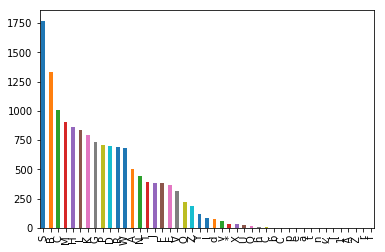

In [24]:
references_df.initial.value_counts().plot(kind='bar')
references_df.initial.value_counts().tail(15)

In [25]:
#also correctly parsed i, e are fine, a are not too bad, leave it
#only very few references are incorrect if they start by lowercase. we accept this
#b is correct
references_df[references_df['initial'] == 'b']

,ref,file,length,initial
3045,"boyd, d. (2014). It’s complicated: The social ...",import2018_176,109,b
3671,"boyd, d. (2009). Why Youth (Heart) Social Netw...",import2015full_285,110,b
4620,"boyd, d. (2009). Why Youth (Heart) Social Netw...",import2015short_285,110,b


Remove overly long references are they are due to badly parsed pdfs:

In [26]:
references_df = references_df[(references_df.length < 1000)]

In [27]:
print('We can parse references from {} documents.'.format(references_df.file.value_counts().shape[0]))

We can parse references from 865 documents.


Example reference, where we can see that our parsing method works quite well:

In [28]:
references_df[references_df.length < 200].sample(5).ref.tolist()

['NGSS Lead States. (2013). Next Generation Science Standards: For States, By States. National Academies Press, Washington DC.',
 'Glaser, B., Strauss, A. (1967). The Discovery of Grounded Theory. Hawthorne, NY: Aldine Publishing Company.',
 'Wilensky, U., & Rand, W. (2015). An introduction to agent-based modeling: modeling natural, social, and engineered complex systems with NetLogo. Cambridge, MA: MIT Press.',
 'McNeill, K. L., & Berland, L. (2017). What is (or should be) scientific evidence use in k-12 classrooms? Journal of Research in Science Teaching, 54(5), 672-689.',
 'Cole, M. (1996). Cultural psychology: A once and future discipline. Harvard University Press.']

# Approach to get author names from references:

For APA style it is easy to extract the year and author of the cited reference, as we know that all authors are listed before (some time reference) Hence we extract the section before "some time reference" and then use the special way that a list of authors is cited in APA style to split up the authors:

In [29]:
def get_authors(sentence, debug = False):
    regex = r'[\S\s]*\((18|19|20)\d{2}[\,\ \w\d]*\)'
    if re.search(regex, sentence):
        s = re.findall(regex, sentence)[0]
        if len(s) > 9:
            return (s)
    elif debug:
        return '#'+sentence
    
    return np.nan


def get_authors_month(sentence, debug = False):
    
    #make sure sentence is encoded in the same way:
    sentence = unicodedata.normalize('NFC', sentence)
    regex = r'[\p{L}\,\ \.\:\;\/\&\-\'\`\(\)\’\–\¨\…\‐\*\´\＆\\]*\([\,\ \p{L}\d\-]*(18|19|20)\d{2}[\,\ \p{L}\d\-]*\)'
    match_bad_year = r'[\S\s]*\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    match_press = r'[\S\s]*\((i|I)n (P|p)ress|manuscript under review\)'
    match_forth = r'[\S\s]*\((f|F)orthcoming\)'
    match_accepted = r'[\S\s]*\((a|A)ccepted\)'
    match_submitted = r'[\S\s]*\((s|S)ubmitted\)'
    match_underreview = r'[\S\s]*\((u|U)nder (R|r)eview\)'
    
    #sentence = sentence.lower()
    if reg.match(regex, sentence):
        s = reg.search(regex, sentence).group(0)
        if len(s) > 9:
            return s
    elif re.match(match_bad_year, sentence):
        return re.search(match_bad_year, sentence).group(0)
    elif re.match(match_press, sentence):
        return re.search(match_press, sentence).group(0)
    elif re.match(match_forth, sentence):
        return re.search(match_forth, sentence).group(0)
    elif re.match(match_accepted, sentence):
        return re.search(match_accepted, sentence).group(0)
    elif re.match(match_submitted, sentence):
        return re.search(match_submitted, sentence).group(0)
    elif re.match(match_underreview, sentence):
        return re.search(match_underreview, sentence).group(0)
    
    return np.nan

Extract authors and month:

In [30]:
references_df['ref_parsed'] = references_df.apply(lambda x: get_authors_month(x['ref']), axis=1)

In [31]:
print('Percentage of unparsed references: {:0.2f}'.format(references_df.ref_parsed.isna().sum()/references_df.ref_parsed.shape[0]))
print('Number of unparsed references: ', references_df[references_df.ref_parsed.isna()].ref.shape[0])
print('Number of properly parsed references: ', references_df.ref_parsed.shape[0])

Percentage of unparsed references: 0.00
Number of unparsed references:  59
Number of properly parsed references:  14680


Taking a look at the unparsed files, we see that many references that could not be parsed are form manuals, or not cited propperly. We do not care about these and can thus discard them.

In [32]:
references_df[references_df.ref_parsed.isna()].ref.head().tolist()  

['American Association for the Advancement of Science (AAAS; 2016). Benchmarks for Science Literacy. New York, Oxford University Press. Retrieved from www.AAAS.org.',
 'Journal of Systems and Software, 86(5), 1390-1407. EEF. (2017). Education Endownment Foundation: Teaching & Learning Toolkit: Collaborative learning.',
 'P21 Framework Definitions (2009). Partnership for 21st Century Skills. Retrieved from http://www.p21.org/storage/documents/P21_Framework_Definitions.pdf.',
 'Dewey, 1913. Dewey, J. (1913). Interest and effort in education. Boston, MA: Riverside Press.',
 'Gilbert (Ed.), Visualization in science education (pp. 121-145). Dordrecht, Netherlands: Springer. NRC. (2006). Learning to think spatially. Washington, D.C.: National Academies Press.']

Taking a peek at how the dataframe currently looks like:

In [33]:
references_df.head()

,ref,file,length,initial,ref_parsed
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,108,L,"Lave, J., & Wenger, E. (1991)"
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,107,M,"Miles, M. B., Huberman, A. M., & Saldana, J. (..."
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,294,P,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish..."
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,269,R,"Rogoff, B. (1995)"
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,215,S,"Shirk, J., Ballard, H., Wilderman, C., Phillip..."


# Extracting year of individual references:
### Extracting the year of publication:

Again we can use the structure of apa citations to extract the year of the citation, in case of 'in press' we just set the year to the year of the file:

In [34]:
def extract_year(x, current_year):
    match_press = r'\(in press|submitted|under review|accepted|forthcoming'
    years = r'\([\w\d\,\ \.\-]*(18|19|20)\d{2}[\,\ \w\d\/\-]*\)'
    year = re.search(years, x)
    if re.search(match_press, x.lower()):
        return current_year
    if year:
        year = year.group(0)
        year = re.findall('\d{4}', year)
        return int(year[0])
    else:
        return np.nan

In [35]:
references_df['pub_year'] = references_df.file.map(lambda x: int(re.search('20[\d]{2}', x).group(0)))

In [36]:
references_df.loc[~references_df.ref_parsed.isna(),'year'] = references_df[~references_df.ref_parsed.isna()].apply(
    lambda x: extract_year(x.ref_parsed, x.pub_year), axis=1)

In [37]:
references_df[references_df.year.isna() & references_df.ref_parsed.notna()].shape

(0, 7)

In [38]:
references_df[references_df.year.isna() & references_df.ref_parsed.notna()].ref_parsed.tolist()

[]

## Look at extracting individual  author names:

For now we look only the the authors that come up in any citation in the paper. So we do not care about order or the specific reference they are associated with:

We again use a regex to extract neighbours, but in the end we use the approach of spliting up the file after a ., or an and or & or ;

In [39]:
authors = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D., Scheintaub, H., Klopfer, E.'

re.findall(r'([A-Z][^\W\d_\-]*\,?\&? [A-Z]\.\,?)', authors)

['Yoon, S.,',
 'Anderson, E.,',
 'Evans, C.,',
 'Park, M.,',
 'Sheldon, J.,',
 'Schoenfeld, I.,',
 'Wendel, D.,',
 'Scheintaub, H.,',
 'Klopfer, E.']

In [40]:
regex = r'([\w\-]*[\,] [A-Z\.\ ]+[\&\,]?)'

In [41]:
#extract authors and clean strings a bit
author_split = r'([\p{L}\-]*[\,] [\p{L}\.\ \-]*[\&\,\.]?)'
author_split_2 = r'([\p{L}\-\.\ ]* [\p{L}\. \ \-]*[\,\.]?)'

reg.findall(author_split_2, 'Selwyn N. (2007)')

['Selwyn N. ']

This function implements the searching for individual authors:

In [54]:
def extract_author(x):
    author_split = r'\.\,| & | and |;'
    list_authors = reg.split(author_split, x)
    list_authors = [name.replace('&', '').replace(',', '').strip() for name in list_authors]
    #remove end of string that isn't name
    list_authors = [re.sub(r'\([\s\S]*\)|\.\.\.|…| et al.|\.', '', name).strip() for name in list_authors if len(name) > 0]
    list_authors = [name for name in list_authors if len(name) > 0]
    return list_authors

We get the individual authors and then change the structure of the dataframe to have one author column containing a single author.

In [55]:
references_df['authors'] =  references_df[~references_df.ref_parsed.isna()].ref_parsed.map(lambda x: extract_author(x))

#go from a list of authors to on author per row

tags = references_df.authors.apply(pd.Series)
tags = tags.rename(columns = lambda x : 'tag_' + str(x))

df = pd.concat([references_df, tags], axis=1)
tag_cols = [c for c in df.columns if 'tag' not in c]
df = df.melt(id_vars=tag_cols)

df['author'] = df['value']
df = df[df.value.notna()].reset_index(drop=True)
del df['variable'], df['authors'], df['value']

We now check the result we get sofar:

In [56]:
df.author.head(20)

0               Lave J
1            Miles M B
2              Pea R D
3             Rogoff B
4              Shirk J
5             Gomoll A
6             Gomoll A
7     Hmelo-Silver C E
8            Mondada L
9          Knoblauch H
10            Schaal S
11           Booth J L
12            Booth JL
13          Empson S B
14          McNeil N M
15           Siegler R
16         Siegler R S
17         Siegler R S
18         Siegler R S
19                Wu H
Name: author, dtype: object

This seems to work quite well, but lets check the short names to in case we have outliers:

We see that there are some issues, but overall not that many

In [57]:
df[df.author.map(lambda x: len(x) < 2)].author.value_counts()

L    4
K    3
J    3
M    3
Z    1
C    1
W    1
D    1
Name: author, dtype: int64

Here we see that the issues are to to irregular listing of names. It makes sense that we have issues extracting these strings:

In [58]:
s = df[df.author.map(lambda x: len(x) < 2)].sample(5)

s.ref_parsed.tolist()

['Schneider, B., Sharma., K., Cuendet, S., Zufferey, G., Dillenbourg, P., & Pea, R. (2016)',
 'Leijen, Ä., Lam, I., Wildschut., L., & Simons, R. (2009)',
 'Howell, J., Tofel-Grehl, C., Fields., D., & Duchamp. G. (2016)',
 'Leijen, Ä., Lam, I., Wildschut., L., & Simons, R. (2009)',
 'Chi., M., & Wylie, R. (2014)']

In [59]:
s.author.tolist()

['K', 'L', 'D', 'L', 'M']

In [60]:
df[df.author == 'M. Chui B. Brown J. Bughin R. Dobbs C. Roxburgh et al.'].ref_parsed.tolist()

[]

In [61]:
extract_author('Manyika, J., M. Chui, B. Brown, J. Bughin, R. Dobbs, C. Roxburgh, et al. (2011)')

['Manyika J', 'M Chui B Brown J Bughin R Dobbs C Roxburgh']

When we look at the extra logn names, we ca also see that the extaction works reasonably well:

(again bearing in mind that some people do not follow the conventions, but there are so few of them that we will exclude them)

In [50]:
df[df.author.map(lambda x: len(x) > 30)].author.value_counts()

Design-Based Research Collective.                                                                                               6
National Academies of Sciences Engineering                                                                                      5
Common Core State Standards Initiative.                                                                                         3
National Academy of Engineering.                                                                                                3
The Design-Based Research Collective.                                                                                           3
National Governors Association Center for Best Practices                                                                        3
Knowledge Forum Japan Research Group.                                                                                           2
M. Chui B. Brown J. Bughin R. Dobbs C. Roxburgh                                           

For an analysis of this dataset check the Dataexploration - References notebook